In [129]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
rng = default_rng()
rvs = stats.uniform().rvs
# rvs = stats.poisson(5, loc=10).rvs
X = random(20, 100, density=0.25, random_state=rng, data_rvs=rvs)
X.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07147431, 0.        , 0.        , ..., 0.        , 0.        ,
        0.41518393],
       [0.        , 0.        , 0.        , ..., 0.72665477, 0.80182433,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.90031048],
       [0.39306901, 0.        , 0.        , ..., 0.        , 0.41930047,
        0.46031454],
       [0.00345502, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

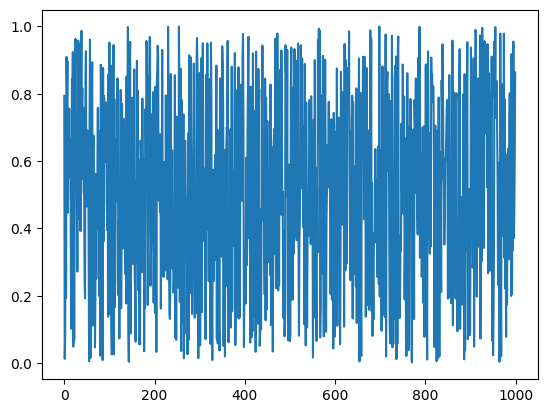

In [4]:
n = 20
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25

y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:25].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [5]:
param = dict(sigma1=1, sigma2=1, sigmay=1, p=100)

In [6]:
def multGaussian(X, mu,sigma):
    m = len(mu)
    sigma2 = np.diag(sigma)
    X = X-mu.T
    p = 1/((2*np.pi)**(m/2)*np.linalg.det(sigma2)**(0.5)) * np.exp(-0.5*np.sum(X.dot(np.linalg.pinv(sigma2))*X,axis=1))
    return p

In [9]:
def diracDelta(x, eps):
    return 1.0/(eps*np.sqrt(2.*np.pi)) * np.exp(-x**2 / (2.*eps**2))
diracDelta = np.vectorize(diracDelta)

In [ ]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 100
gamma = 0.1
rho = 1

In [ ]:
p = len(X[1])
n = len(X)
b = p + n
theta = np.array([np.zeros(p)]).T
AtA, Atz, z = [], [], []
for t in range(niter):
    print("Start of %sth iteration" % str(t))
    for i in range(b):
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            AtA.append(np.matmul(A.T, A))
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * np.linalg.norm(np.matmul(A[0], theta))/2)))
            w2 = 1 - w1
            U = np.random.uniform()
            if U > w1:
                mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                sigmaz = 1 - sigsig**2
                z.append(np.random.normal(mu, sigmaz))
            else:
                z.append(0)
            # print(A)
            Atz.append(A.T * z[i])
            
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            AtA.append(np.matmul(A.T, A))
            z.append(y[i-p] / sigmay)
            Atz.append(A.T * z[i])
            # print((A.T * z[i]).shape)
    # print(sum(AtA))
    print("End of sampling z values")
    sumAAtinv = np.linalg.inv(sum(AtA))
    mu_theta = np.matmul(sumAAtinv, sum(Atz))
    # print(mu_theta.shape)
    sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
    L = np.linalg.cholesky(sigma_theta)
    # print(L)
    print("Start of sampling theta")
    theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
    theta = theta_new
    print(theta.shape)
    # break
    AtA, Atz, z = [], [], []
    print("-------------------------------------------------------")
    

In [124]:
def splitGibbs(sigma1, sigma2, sigmay, p, n, niter=1000):
    gamma = 0.1
    rho = 1
    b = p + n
    theta = np.array([np.zeros(p)]).T
    AtA, Atz, z = [], [], []
    samples = np.array()
    for t in range(niter):
        print("Start of %sth iteration" % str(t))
        for i in range(b):
            if i <= p-1:
                e = np.array([np.zeros(p)])
                e[0][i] = 1
                A = e * 1/sigma2
                AtA.append(np.matmul(A.T, A))
                sigsig = sigma2 / sigma1
                w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * np.linalg.norm(np.matmul(A[0], theta))/2)))
                w2 = 1 - w1
                U = np.random.uniform()
                if U > w1:
                    mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                    sigmaz = 1 - sigsig**2
                    z.append(np.random.normal(mu, sigmaz))
                else:
                    z.append(0)
                # print(A)
                Atz.append(A.T * z[i])
                
            else:
                X_t = X[i-p].reshape(1, p)
                A = X_t / sigmay
                AtA.append(np.matmul(A.T, A))
                z.append(y[i-p] / sigmay)
                Atz.append(A.T * z[i])
                # print((A.T * z[i]).shape)
        # print(sum(AtA))
        print("End of sampling z values")
        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        # print(mu_theta.shape)
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        # print(L)
        print("Start of sampling theta")
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        # print(theta.shape)
        # break
        AtA, Atz, z = [], [], []
        samples.append(theta)
        print("-------------------------------------------------------")
    
    return samples

In [ ]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 100

In [143]:
multiESS(pd.DataFrame(np.reshape(trace, (10000, 50))), b="sqroot")

InvalidIndexError: (array([   0,    1,    2, ..., 9997, 9998, 9999]), slice(None, None, None))

In [126]:
trace = splitGibbs(sigma1 = 1, sigma2= 0.1, sigmay= 1, p = len(X[1]), n = len(X),  niter=10000)
len(trace)

Start of 0th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 1th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 2th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 3th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 4th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 5th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 6th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 7th iteration
End of sampling z values
Start of sampling theta
--------------------------------

10000

In [134]:
import numpy as np
from scipy.stats import chi2
from scipy.special import gammaln


def fminESS(p, alpha=.05, eps=.05, ess=None):
    """
    Minimum effective sample size
    """

    crit = chi2.ppf(1 - alpha, p)
    foo = 2. / p

    if ess is None:
        logminESS = foo * np.log(2.) + np.log(np.pi) - foo * np.log(p) -\
            foo * gammaln(p / 2.) - 2. * np.log(eps) + np.log(crit)
        return np.round(np.exp(logminESS))
    else:
        if isinstance(ess, str):
            raise ValueError("Only numeric entry allowed for ess")
        logEPS = .5 * foo * np.log(2.) + .5 * np.log(np.pi) -\
            .5 * foo * np.log(p) - .5 * foo * gammaln(p / 2.) -\
            .5 * np.log(ess) + .5 * np.log(crit)
        return np.exp(logEPS)


def multiESS(X, b='sqroot', Noffsets=10, Nb=None):
    """
    Compute multivariate effective sample size of a single Markov chain X,
    using the multivariate dependence structure of the process.
    X: MCMC samples of shape (n, p)
    n: number of samples
    p: number of parameters
    b: specifies the batch size for estimation of the covariance matrix in
       Markov chain CLT. It can take a numeric value between 1 and n/2, or a
       char value between:
    'sqroot'    b=floor(n^(1/2)) (for chains with slow mixing time; default)
    'cuberoot'  b=floor(n^(1/3)) (for chains with fast mixing time)
    'lESS'      pick the b that produces the lowest effective sample size
                for a number of b ranging from n^(1/4) to n/max(20,p); this
                is a conservative choice
    If n is not divisible by b Sigma is recomputed for up to Noffsets subsets
    of the data with different offsets, and the output mESS is the average over
    the effective sample sizes obtained for different offsets.
    Nb specifies the number of values of b to test when b='less'
    (default NB=200). This option is unused for other choices of b.
    Original source: https://github.com/lacerbi/multiESS
    Reference:
    Vats, D., Flegal, J. M., & Jones, G. L. "Multivariate Output Analysis
    for Markov chain Monte Carlo", arXiv preprint arXiv:1512.07713 (2015).
    """

    # MCMC samples and parameters
    n, p = X.shape

    if p > n:
        raise ValueError(
            "More dimensions than data points, cannot compute effective "
            "sample size.")

    # Input check for batch size B
    if isinstance(b, str):
        if b not in ['sqroot', 'cuberoot', 'less']:
            raise ValueError(
                "Unknown string for batch size. Allowed arguments are "
                "'sqroot', 'cuberoot' and 'lESS'.")
        if b != 'less' and Nb is not None:
            raise Warning(
                "Nonempty parameter NB will be ignored (NB is used "
                "only with 'lESS' batch size B).")
    else:
        if not 1. < b < (n / 2):
            raise ValueError(
                "The batch size B needs to be between 1 and N/2.")

    # Compute multiESS for the chain
    mESS = multiESS_chain(X, n, p, b, Noffsets, Nb)

    return mESS


def multiESS_chain(Xi, n, p, b, Noffsets, Nb):
    """
    Compute multiESS for a MCMC chain.
    """

    if b == 'sqroot':
        b = [int(np.floor(n ** (1. / 2)))]
    elif b == 'cuberoot':
        b = [int(np.floor(n ** (1. / 3)))]
    elif b == 'less':
        b_min = np.floor(n ** (1. / 4))
        b_max = max(np.floor(n / max(p, 20)), np.floor(np.sqrt(n)))
        if Nb is None:
            Nb = 200
        # Try NB log-spaced values of B from B_MIN to B_MAX
        b = set(map(int, np.round(np.exp(
            np.linspace(np.log(b_min), np.log(b_max), Nb)))))

    # Sample mean
    theta = np.mean(Xi, axis=0)
    # Determinant of sample covariance matrix
    if p == 1:
        detLambda = np.cov(Xi.T)
    else:
        detLambda = np.linalg.det(np.cov(Xi.T))

    # Compute mESS
    mESS_i = []
    for bi in b:
        mESS_i.append(multiESS_batch(Xi, n, p, theta, detLambda, bi, Noffsets))
    # Return lowest mESS
    mESS = np.min(mESS_i)

    return mESS


def multiESS_batch(Xi, n, p, theta, detLambda, b, Noffsets):
    """
    Compute multiESS for a given batch size B.
    """

    # Compute batch estimator for SIGMA
    a = int(np.floor(n / b))
    Sigma = np.zeros((p, p))
    offsets = np.sort(list(set(map(int, np.round(
        np.linspace(0, n - np.dot(a, b), Noffsets))))))

    for j in offsets:
        # Swapped a, b in reshape compared to the original code.
        Y = Xi[j + np.arange(a * b), :].reshape((a, b, p))
        Ybar = np.squeeze(np.mean(Y, axis=1))
        Z = Ybar - theta
        for i in range(a):
            if p == 1:
                Sigma += Z[i] ** 2
            else:
                Sigma += Z[i][np.newaxis, :].T * Z[i]

    Sigma = (Sigma * b) / (a - 1) / len(offsets)
    mESS = n * (detLambda / np.linalg.det(Sigma)) ** (1. / p)

    return mESS

In [ ]:
def effectiveSampleSize(data, stepSize = 1) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag
  #varGammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 :
         varStat += 2.0*s
      else :
        break
      
  # standard error of mean
  # stdErrorOfMean = Math.sqrt(varStat/samples);

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess